In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skfuzzy import cmeans
from scipy.spatial.distance import cdist
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

In [2]:

def extract_clusters(image_path, n_clusters, m=2.0, max_iter=150, error=1e-5):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, c = image.shape
    reshaped_image = image.reshape(-1, 3).T  # Transpose for FCM

    # Fuzzy C-Means clustering
    centers, u, _, _, _, _, _ = cmeans(reshaped_image, n_clusters, m=m, error=error, maxiter=max_iter, init=None)

    # Assign each pixel to the cluster with the highest membership value
    labels = np.argmax(u, axis=0)
    centers = centers.astype(np.uint8)

    # Create combined cluster image
    combined_image = np.zeros_like(reshaped_image.T)

    # Set up the subplot grid (including original image)
    fig, axes = plt.subplots(1, n_clusters + 2, figsize=(25, 10))
    fig.suptitle("Image Clustering (Fuzzy C-Means)", fontsize=24)

    # Plot the original image
    axes[0].imshow(image)
    axes[0].axis('off')
    axes[0].set_title("Original Image", fontsize=16)

    for cluster_id in range(n_clusters):
        # Mask for the current cluster
        mask = (labels == cluster_id)
        cluster_image = np.zeros_like(reshaped_image.T)
        cluster_image[mask] = centers[cluster_id]
        combined_image[mask] = centers[cluster_id]

        # Reshape for display
        cluster_image = cluster_image.reshape(h, w, 3)

        # Plot the individual cluster
        axes[cluster_id + 1].imshow(cluster_image)
        axes[cluster_id + 1].axis('off')
        axes[cluster_id + 1].set_title(f"Cluster {cluster_id}\nCenter Color: {centers[cluster_id]}", fontsize=16)

        # Print the center color
        print(f"Cluster {cluster_id} Center Color: {centers[cluster_id]}")

    # Display the combined image
    combined_image = combined_image.reshape(h, w, 3)
    axes[-1].imshow(combined_image)
    axes[-1].axis('off')
    axes[-1].set_title("Combined Cluster Image", fontsize=16)

    plt.show()

    # Calculate metrics
    dbi = davies_bouldin_score(reshaped_image.T, labels)
    wcss = np.sum(np.min(cdist(reshaped_image.T, centers, 'euclidean'), axis=1) ** 2)
    reshaped_for_silhouette = reshaped_image.T 
    silhouette = silhouette_score(reshaped_for_silhouette, labels)

    print("\nCluster Quality Metrics:")
    print(f"Davies-Bouldin Index (DBI): {dbi:.4f}")
    print(f"Within-Cluster Sum of Squares (WCSS): {wcss:.4f}")
    print(f"Silhouette Score: {silhouette:.4f}")

    return centers, labels

Cluster 0 Center Color: [3 1 2]
Cluster 1 Center Color: [232 147   1]
Cluster 2 Center Color: [180 101   1]
Cluster 3 Center Color: [156  78   5]


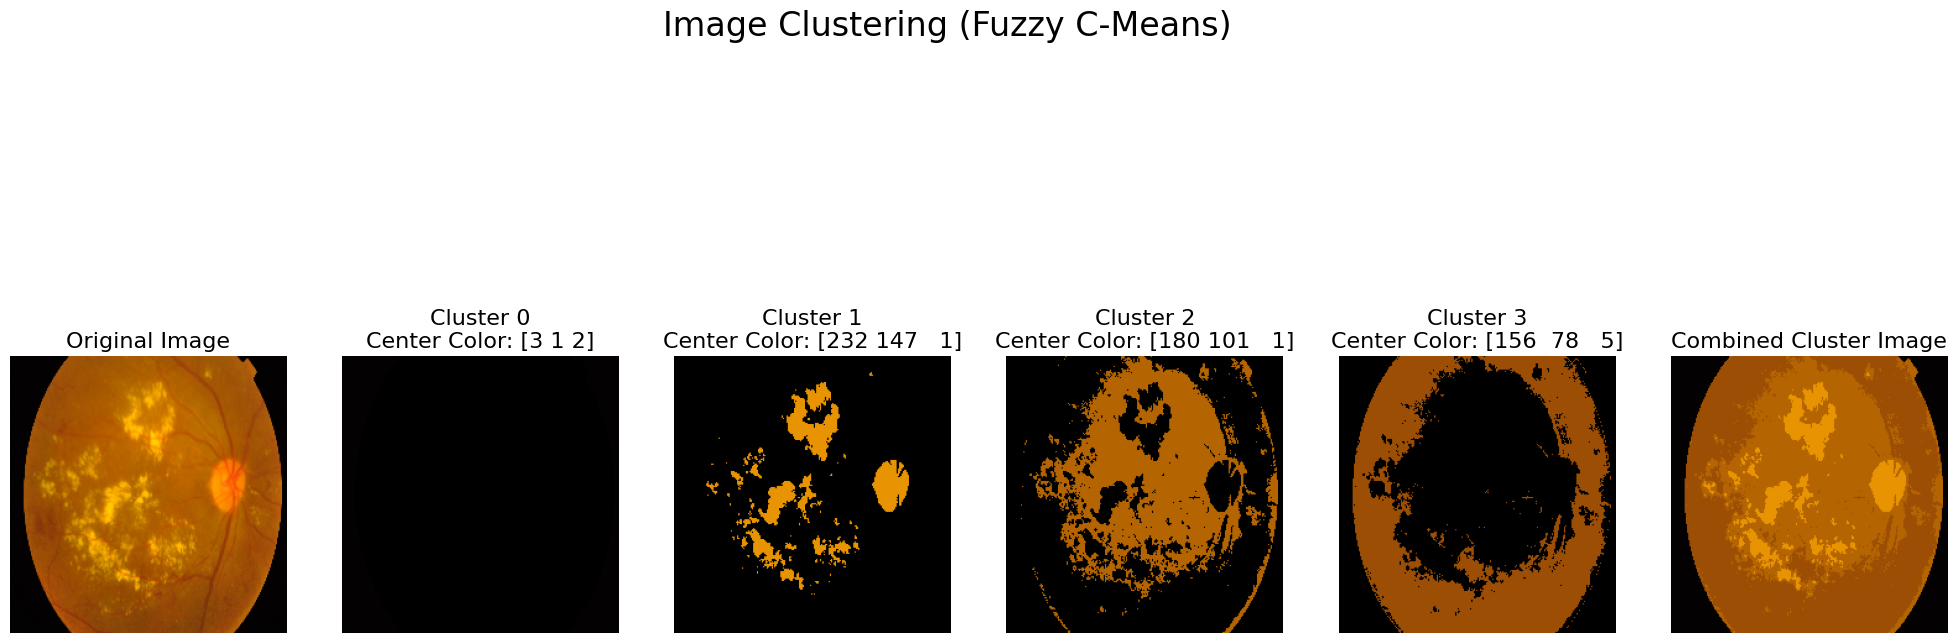


Cluster Quality Metrics:
Davies-Bouldin Index (DBI): 0.5033
Within-Cluster Sum of Squares (WCSS): 10673266.0000
Silhouette Score: 0.5830


In [3]:
centers, labels = extract_clusters("DR3.png", n_clusters=4)

In [4]:
def enhance_cluster(image_path, centers, labels, target_cluster_id, brightness=0, contrast=0):
    # Load the original image
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    h, w, c = original_image.shape
    reshaped_image = original_image.reshape(-1, 3)
    
    # Create a copy for the enhanced output
    enhanced_image = reshaped_image.copy()
    
    # Create a mask for the specific target cluster
    mask = (labels == target_cluster_id)
    
    # Extract only the target cluster pixels
    cluster_pixels = reshaped_image[mask]
    
    # Apply brightness and contrast adjustments
    alpha = 1 + (contrast / 100.0)  # Contrast scaling
    beta = int(brightness)  # Brightness offset
    enhanced_pixels = cv2.convertScaleAbs(cluster_pixels, alpha=alpha, beta=beta)
    
    # Replace the original cluster pixels with the enhanced ones
    enhanced_image[mask] = enhanced_pixels
    
    # Reshape back to the original image dimensions
    enhanced_image = enhanced_image.reshape(h, w, 3)
    
    # Plot both the original and enhanced images
    plt.figure(figsize=(25, 15))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.axis('off')
    plt.title("Original Image", fontsize=20)

    # Plot the enhanced image
    plt.subplot(1, 2, 2)
    plt.imshow(enhanced_image)
    plt.axis('off')
    plt.title(f"Enhanced Image (Cluster {target_cluster_id}, Brightness: {brightness}, Contrast: {contrast})", fontsize=20)

    plt.show()
    
    return enhanced_image

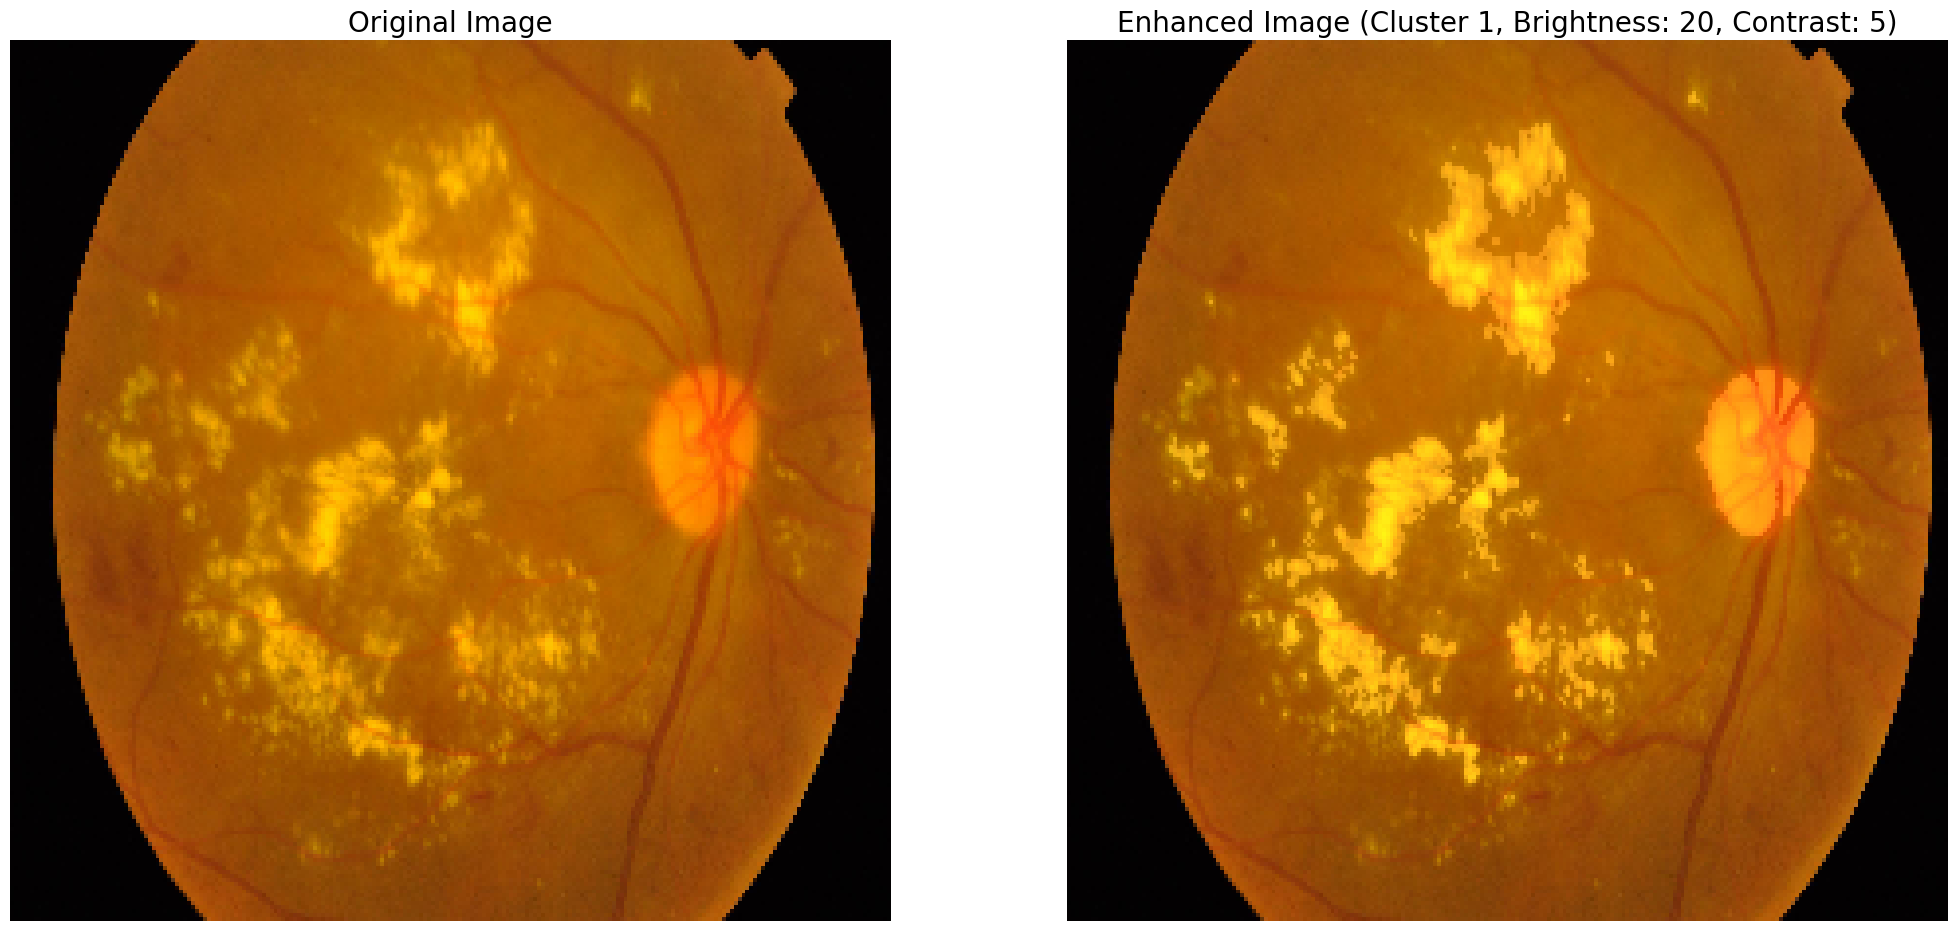

In [6]:
enhanced_image = enhance_cluster(
    image_path="DR3.png",
    centers=centers,
    labels=labels,
    target_cluster_id=1, 
    brightness=20,
    contrast=5
)

In [7]:

def enhance_cluster_with_clahe(image_path, centers, labels, target_cluster_id, clip_limit=1.45, tile_grid_size=(8, 8)):
    # Load the original image
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    h, w, c = original_image.shape
    reshaped_image = original_image.reshape(-1, 3)
    
    # Create a copy for the enhanced output
    enhanced_image = reshaped_image.copy()
    
    # Create a mask for the specific target cluster
    mask = (labels == target_cluster_id)
    
    # Extract only the target cluster pixels
    cluster_pixels = reshaped_image[mask].reshape(-1, 3)
    
    # Convert the cluster pixels to LAB color space
    lab_pixels = cv2.cvtColor(cluster_pixels.reshape(-1, 1, 3), cv2.COLOR_RGB2LAB)
    
    # Apply CLAHE to the L (lightness) channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    lab_pixels[:, :, 0] = clahe.apply(lab_pixels[:, :, 0])
    
    # Convert back to RGB
    enhanced_pixels = cv2.cvtColor(lab_pixels, cv2.COLOR_LAB2RGB).reshape(-1, 3)
    
    # Replace the original cluster pixels with the enhanced ones
    enhanced_image[mask] = enhanced_pixels
    
    # Reshape back to the original image dimensions
    enhanced_image = enhanced_image.reshape(h, w, 3)
    
    # Plot both the original and enhanced images
    plt.figure(figsize=(25, 15))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.axis('off')
    plt.title("Original Image", fontsize=20)

    # Plot the enhanced image
    plt.subplot(1, 2, 2)
    plt.imshow(enhanced_image)
    plt.axis('off')
    plt.title(f"Enhanced Image (Cluster {target_cluster_id}, CLAHE Clip Limit: {clip_limit})", fontsize=20)

    plt.show()
    
    return enhanced_image


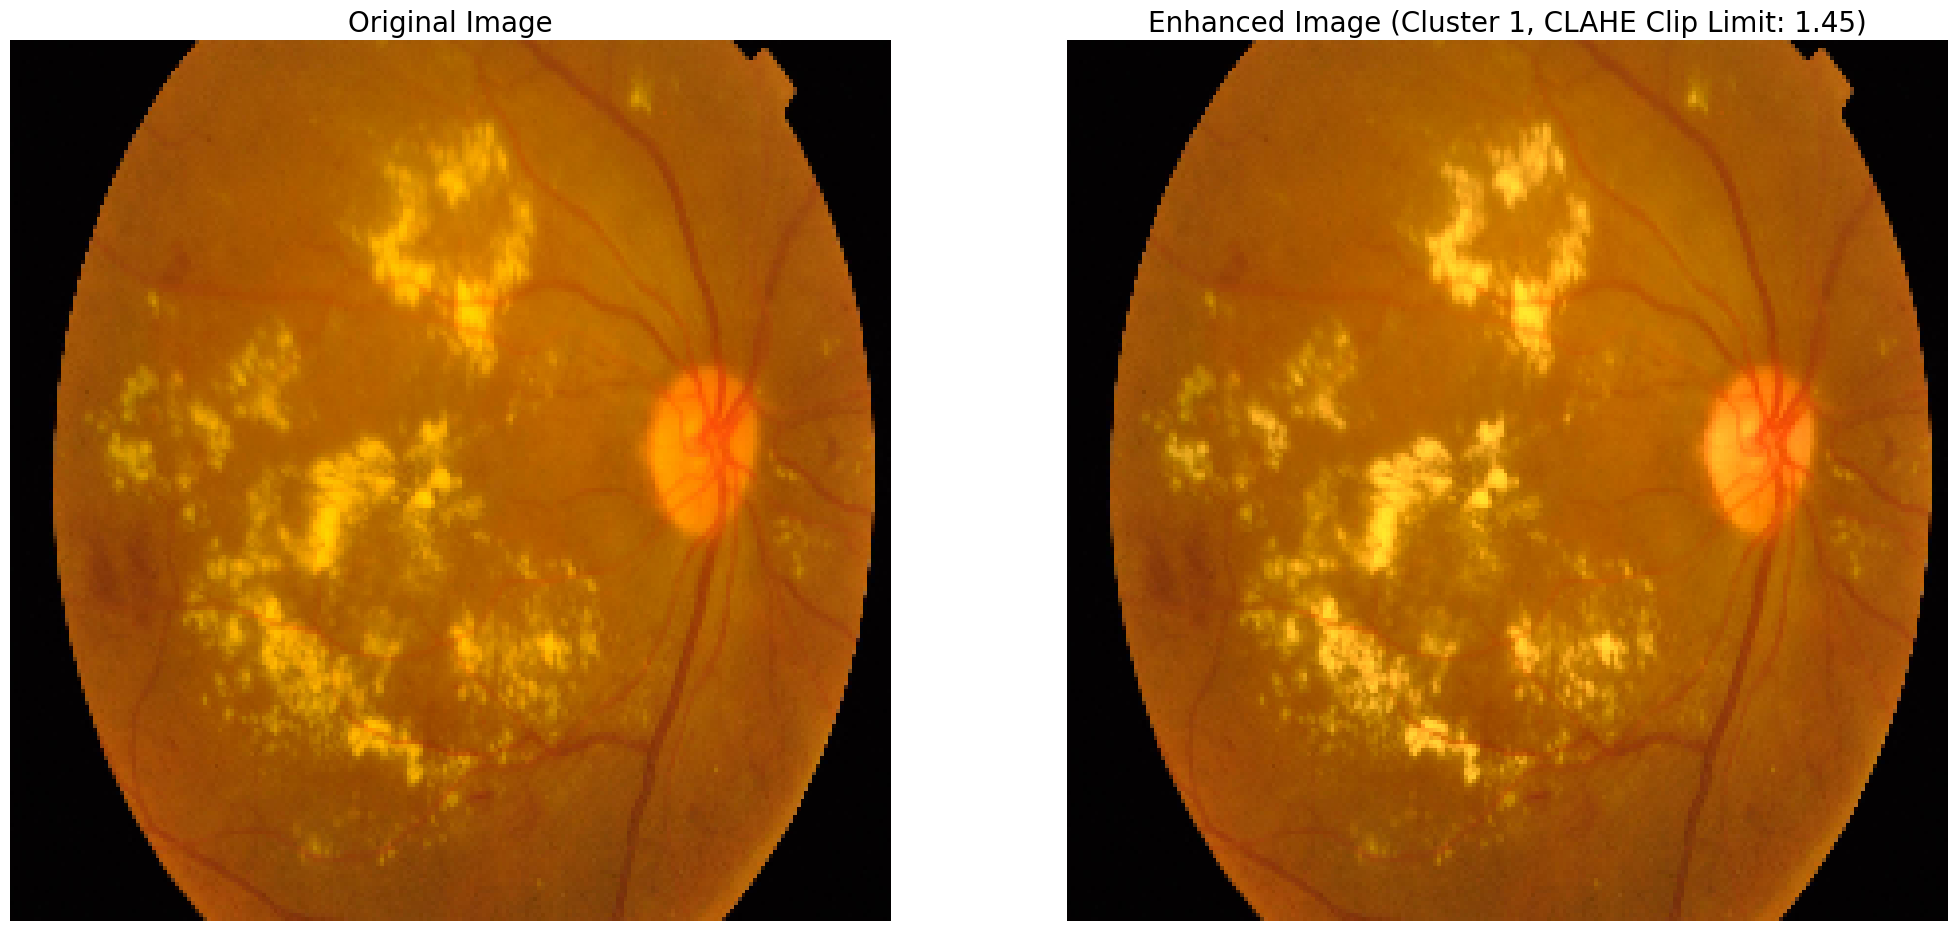

In [10]:
enhanced_image = enhance_cluster_with_clahe(
    image_path= "DR3.png", 
    centers= centers, 
    labels=labels, 
    target_cluster_id=1
)
